## ALBERT 의 Cross-layer 파라미터 sharing

### ALBERT 모델 로딩과 입력 값 생성

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers

In [1]:
import torch
from transformers import AlbertModel, AlbertTokenizer

In [3]:
model_nm = 'albert-large-v1'

model = AlbertModel.from_pretrained(model_nm)

Some weights of the model checkpoint at albert-large-v1 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
tokenizer = AlbertTokenizer.from_pretrained(model_nm)

In [7]:
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1

outputs = model(input_ids)
last_hidden_states = outputs[0]

### 입력 값에 대한 히든 스테이트 생성

In [8]:
emb_output = model.embeddings(input_ids)
hidden_states = model.encoder.embedding_hidden_mapping_in(emb_output)

### 각 레이어마다의 히든 스테이트 변화량 계산

In [13]:
n_layers = model.encoder.config.num_hidden_layers
head_mask = [None] * n_layers

attention_mask = torch.ones(input_ids.shape)
extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)  # fp16 compatibility
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

In [14]:
dist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
distance_list = []
for i in range(n_layers):
    input_embedding = hidden_states#.view(-1, 8*768)
    layer_out = model.encoder.albert_layer_groups[0](
        hidden_states,
        extended_attention_mask,
        head_mask[0*n_layers:(0+1)*n_layers]
    )
    hidden_states = layer_out[0]
    output_embedding = hidden_states
    
    distance = torch.dist(input_embedding, output_embedding, p=2)
    print(i, hidden_states.shape, input_embedding.shape, output_embedding.shape, distance)
    distance_list.append(distance)

0 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(39.1129, grad_fn=<DistBackward0>)
1 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(20.0344, grad_fn=<DistBackward0>)
2 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(16.1824, grad_fn=<DistBackward0>)
3 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(12.3042, grad_fn=<DistBackward0>)
4 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(9.8304, grad_fn=<DistBackward0>)
5 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(7.6768, grad_fn=<DistBackward0>)
6 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(6.3892, grad_fn=<DistBackward0>)
7 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(5.5773, grad_fn=<DistBackward0>)
8 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) torch.Si

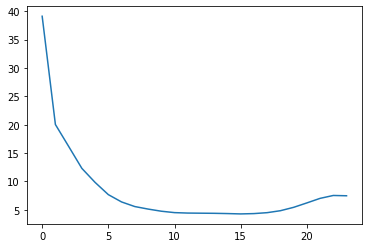

In [15]:
import matplotlib.pyplot as plt
plt.plot([d.detach().numpy() for d in distance_list])
plt.show()